In [30]:
# This serves as a template which will guide you through the implementation of this task.  It is advised
# to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps
# First, we import necessary libraries:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("train.csv")

print("Training data:")
print("Shape:", train_df.shape)
print(train_df.head(2))
print('\n')

# Load test data
test_df = pd.read_csv("test.csv")

print("Test data:")
print(test_df.shape)
print(test_df.head(2))

# Dummy initialization of the X_train, X_test and y_train   
X_train = np.zeros_like(train_df.drop(['price_CHF'],axis=1))
y_train = np.zeros_like(train_df['price_CHF'])
X_test = np.zeros_like(test_df)

Training data:
Shape: (900, 11)
   season  price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
0  spring        NaN   9.644028  -1.686248  -1.748076  -3.666005        NaN   
1  summer        NaN   7.246061  -2.132377  -2.054363  -3.295697  -4.104759   

   price_UK  price_ITA  price_POL  price_SVK  
0 -1.822720  -3.931031        NaN  -3.238197  
1 -1.826021        NaN        NaN  -3.212894  


Test data:
(100, 10)
   season  price_AUS  price_CZE  price_GER  price_ESP  price_FRA  price_UK  \
0  spring        NaN   0.472985   0.707957        NaN  -1.136441 -0.596703   
1  summer  -1.184837   0.358019        NaN  -3.199028  -1.069695       NaN   

   price_ITA  price_POL  price_SVK  
0        NaN   3.298693   1.921886  
1  -1.420091   3.238307        NaN  


In [38]:
train_df.describe()

,price_AUS,price_CHF,price_CZE,price_GER,price_ESP,price_FRA,price_UK,price_ITA,price_POL,price_SVK
count,638.000000,631.000000,632.000000,631.000000,631.000000,636.000000,613.000000,634.000000,635.000000,619.000000
mean,-0.665411,4.538611,-0.221514,-0.421923,-4.737647,-2.914028,-1.518137,-2.686282,-0.296811,-0.643735
std,1.016447,3.328953,1.192286,1.155131,1.186441,1.102510,1.613119,1.150795,2.012512,2.093138
min,-2.362783,-3.736940,-2.147384,-2.238546,-6.891480,-4.428215,-3.940520,-4.330588,-2.912800,-3.499810
25%,-1.613550,2.640888,-1.522282,-1.633691,-5.688912,-3.884357,-2.643156,-3.737076,-2.354075,-2.923394
50%,-0.577244,3.872916,0.198743,-0.251429,-4.514822,-3.291359,-1.863632,-2.881648,-0.420106,-0.443855
75%,0.005234,7.736682,0.784038,0.646908,-3.603188,-2.025672,-0.270304,-1.817957,1.605009,1.536044
max,1.316798,9.933313,1.710173,1.659539,-2.858268,0.000619,1.624482,0.943226,3.421927,2.527192


In [12]:
# Pre-processing of the data

# 1. Filter out zero or near-zero variance features.
# 2. Perform imputation if required.
# 3. Normalize to resolve numeric feature skewness.
# 4. Standardize (center and scale) numeric features.
# 5. Perform dimension reduction (e.g., PCA) on numeric features.
# 6. One-hot or dummy encode categorical features.
# 7. VIF test
# 8. Feature selection 

# 1. feature variances
feature_variances = train_df.var()

threshold_variance = 0.3 # this value could be varied depending if we want 
selected_features = feature_variances[feature_variances > threshold_variance].index

train_df_filtered = train_df[selected_features].join(train_df["season"])


<ipython-input-12-7f75826bacb3>:13: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_variances = train_df.var()


In [20]:
# 2. Missingness per feature
missing_values_per_season = train_df_filtered.groupby("season").apply(lambda x: (x.isna().sum()))
print("Number of missing values:")
print(missing_values_per_season)
print("\n")

missing_values_per_season_perct = train_df_filtered.groupby("season").apply(lambda x: 100*((x.isna().sum())/len(x)))
print("Percentage of missingness:")
print(missing_values_per_season_perct)

# Conclusion > similar percentage of missing values per seaosn and per country (feature), with very high values (~30%)

Number of missing values:
        price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
season                                                                     
autumn         74         64         72         65         70         65   
spring         70         60         67         65         61         68   
summer         57         74         65         65         68         63   
winter         61         71         64         74         70         68   

        price_UK  price_ITA  price_POL  price_SVK  season  
season                                                     
autumn        62         70         62         71       0  
spring        79         68         70         67       0  
summer        72         71         68         72       0  
winter        74         57         65         71       0  


Percentage of missingness:
        price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
season                                              

In [21]:
# Define two functions to input missing values
def impute_avg_per_season(df, season_col="season"):
    return df.groupby(season_col).transform(lambda x: x.fillna(x.mean()))

In [24]:
def impute_with_linear_regression(df, target_col, season_col="season"):
    imputed_df = df.copy()
    seasons = df[season_col].unique()

    for season in seasons:
        season_data = df[df[season_col] == season]
        train_data = season_data.dropna()
        missing_data = season_data[season_data[target_col].isna()]

        if len(train_data) == 0 or len(missing_data) == 0:
            continue

        X_train = train_data.drop([target_col, season_col], axis=1)
        y_train = train_data[target_col]
        X_missing = missing_data.drop([target_col, season_col], axis=1)

        model = LinearRegression()
        model.fit(X_train, y_train)
        imputed_values = model.predict(X_missing)

        imputed_df.loc[missing_data.index, target_col] = imputed_values

    return imputed_df

In [29]:
train_df_avg_imputed = impute_avg_per_season(train_df_filtered)

for feature_name in train_df.columns:
  if feature_name != "price_CHF":
    train_df_linear_imputed = impute_with_linear_regression(train_df_filtered, feature_name)


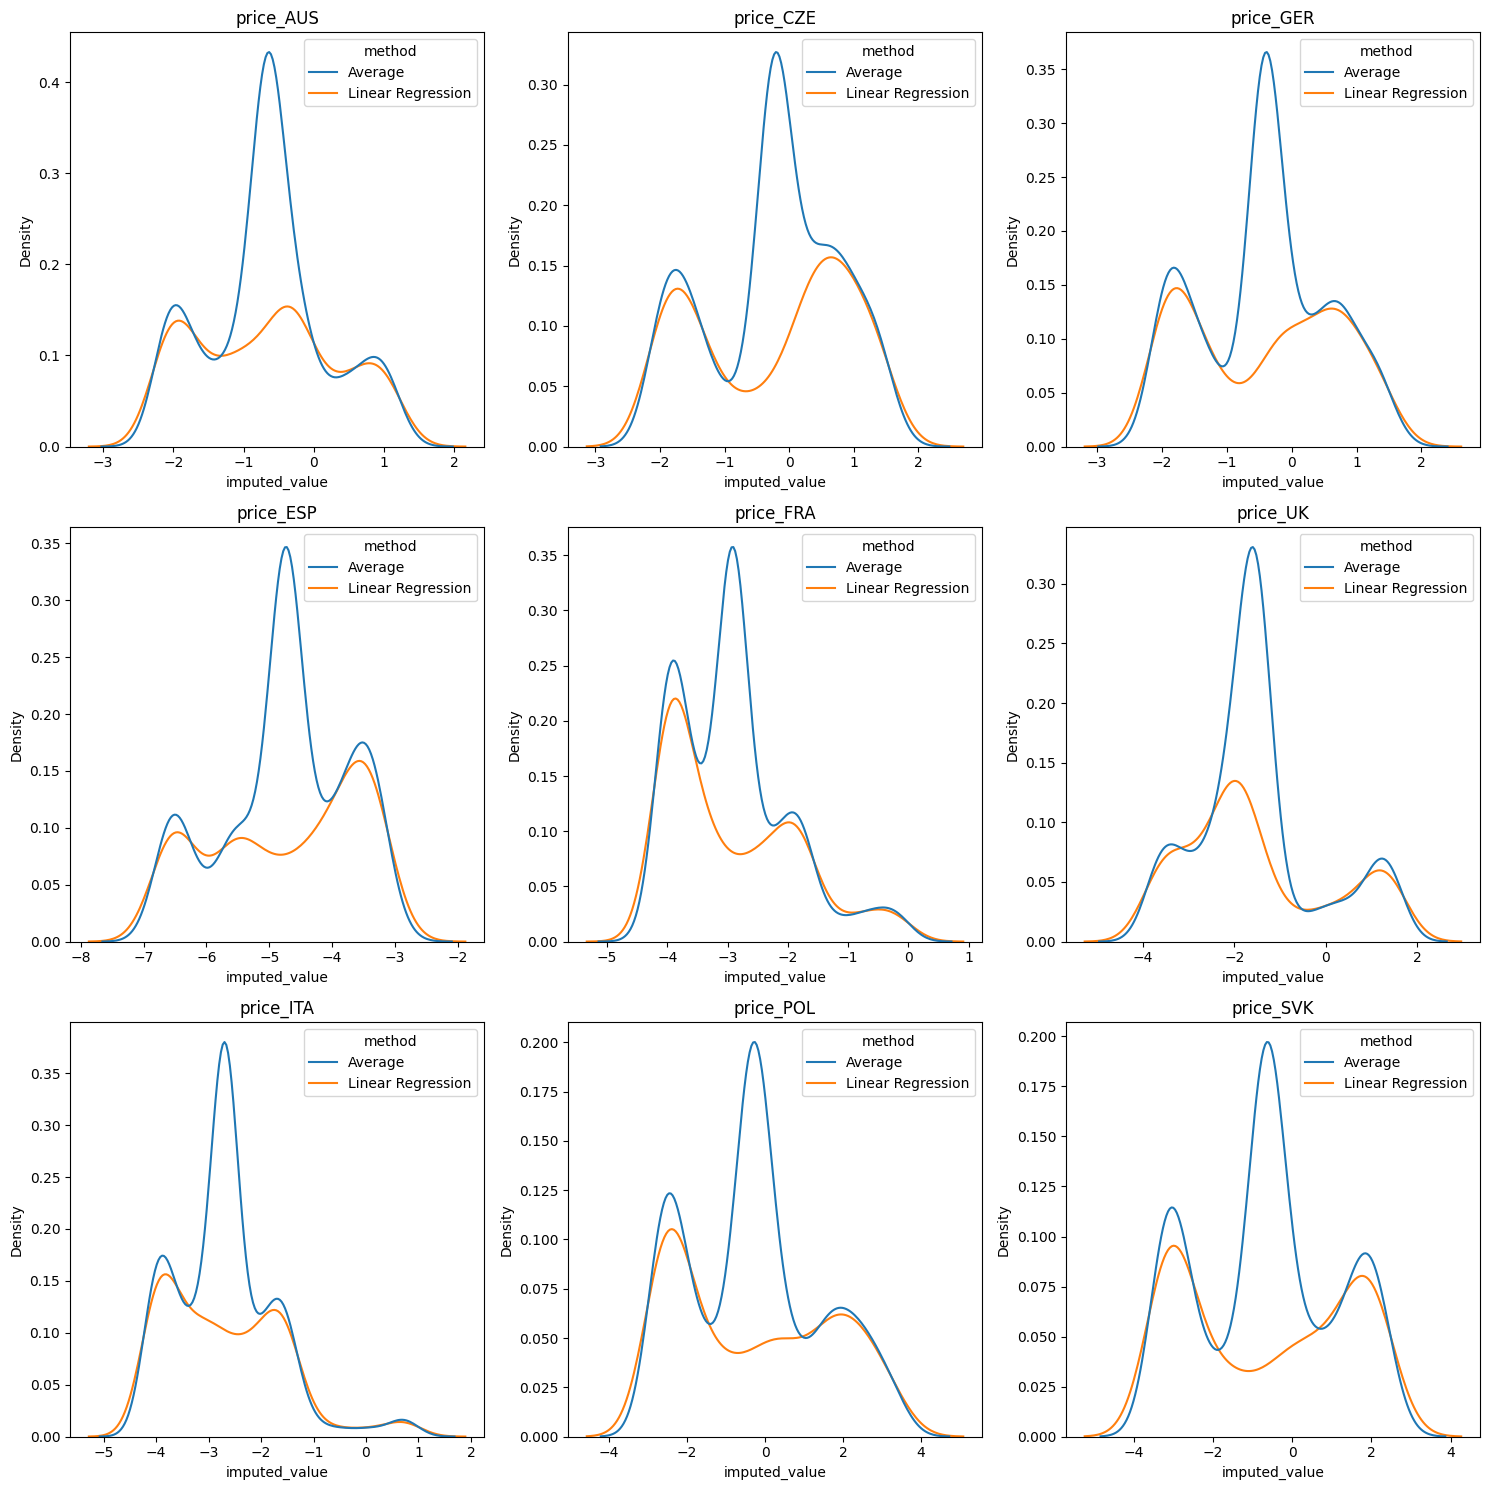

In [51]:
# Let us now plot the distribution of all features after imputation

feature_names = [col for col in train_df.columns if col not in ['season', 'price_CHF']]

avg_imputed_values = train_df_avg_imputed[feature_names].stack().reset_index().rename(columns={'level_1': 'feature', 0: 'avg_imputed'})
avg_imputed_values['method'] = 'Average'

linear_imputed_values = train_df_linear_imputed[feature_names].stack().reset_index().rename(columns={'level_1': 'feature', 0: 'linear_imputed'})
linear_imputed_values['method'] = 'Linear Regression'

imputed_values = pd.concat([avg_imputed_values.rename(columns={'avg_imputed': 'imputed_value'}), linear_imputed_values.rename(columns={'linear_imputed': 'imputed_value'})])

# Create a 3x3 plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    sns.kdeplot(
        data=imputed_values[imputed_values['feature'] == feature],
        x='imputed_value',
        hue='method',
        ax=ax
    )
    ax.set_title(feature)

plt.tight_layout()
plt.show()

# As an initial analysis, it seems the linear regression imputation is a better option.
# Averaging produces an over representation of the average price, which is very similar, regardless of the season

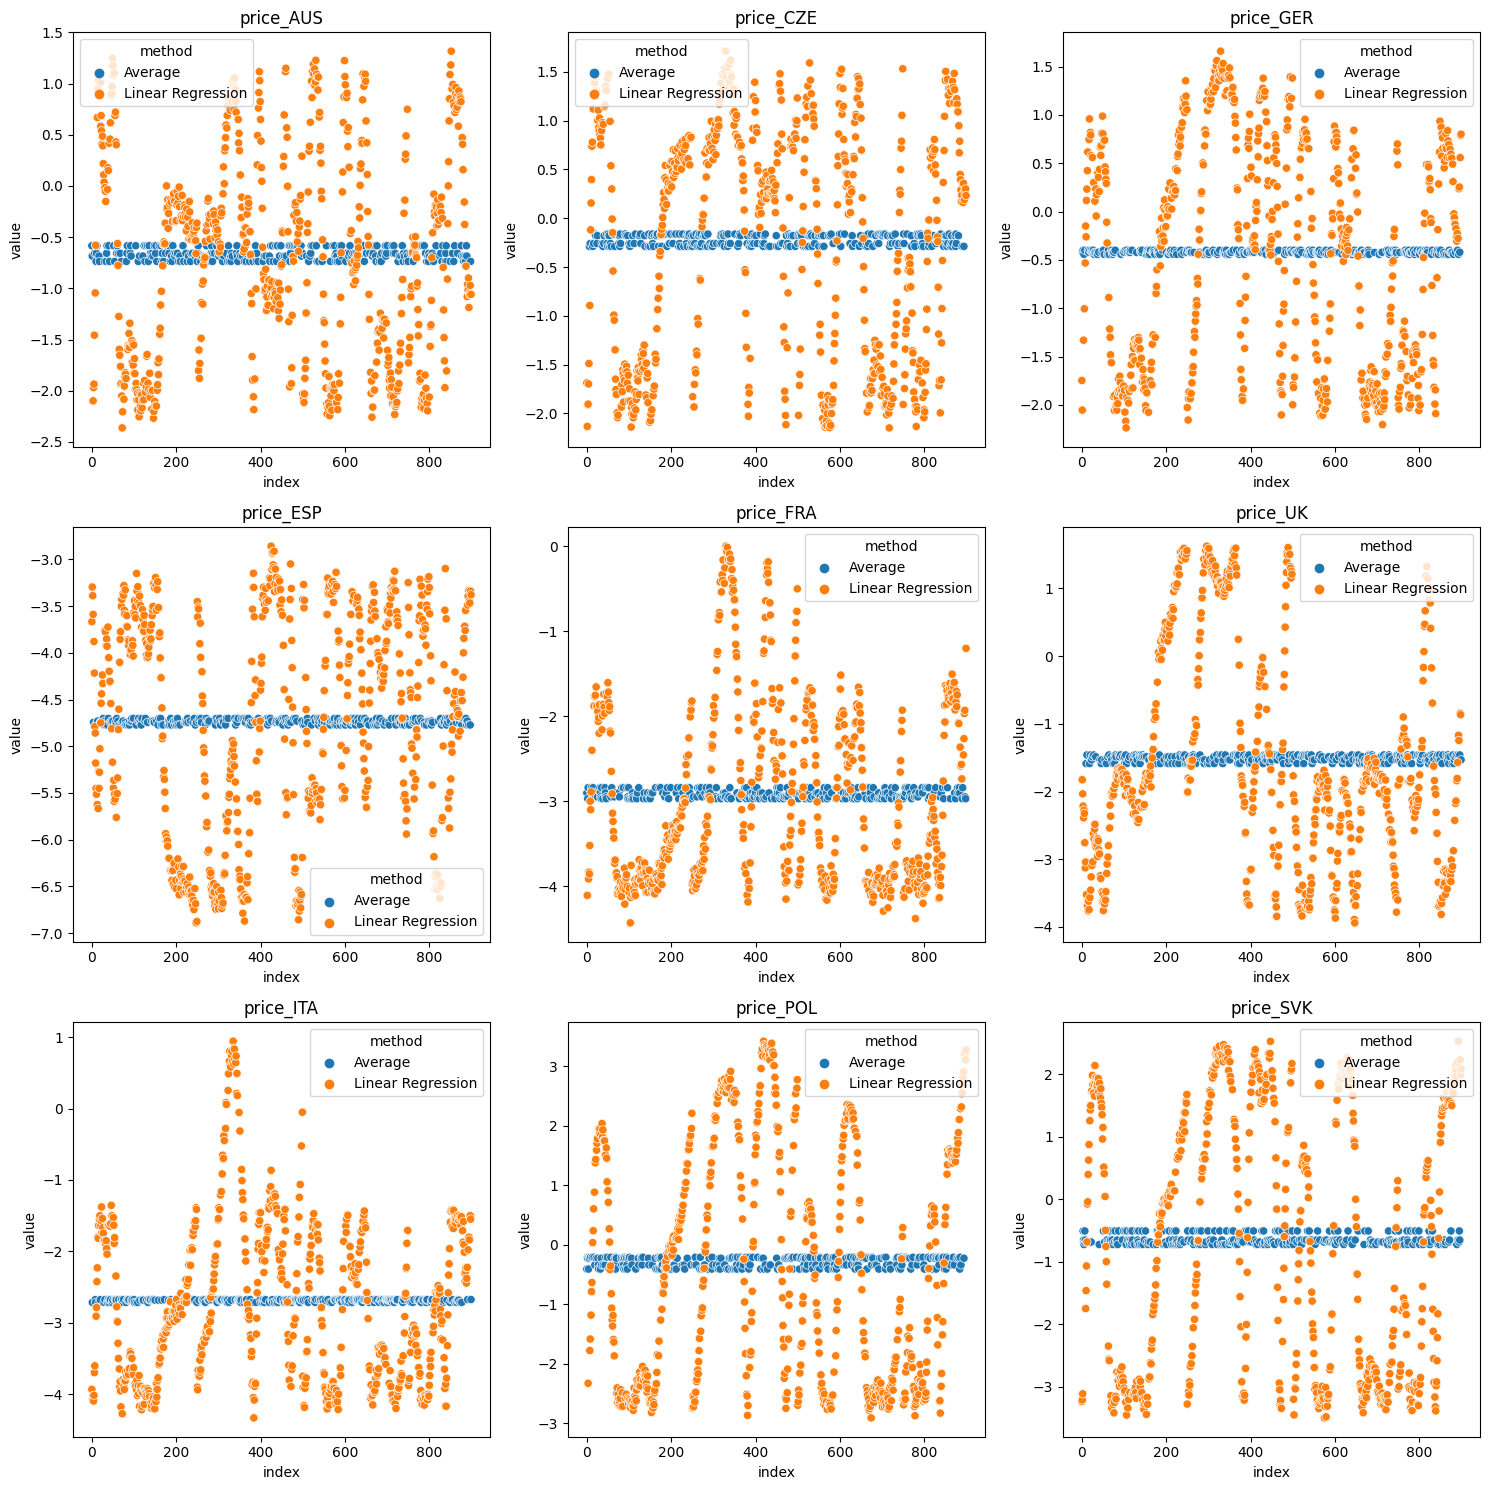

In [57]:
# Add the index to the imputed DataFrames
avg_imputed_values = train_df_avg_imputed.reset_index()
linear_imputed_values = train_df_linear_imputed.reset_index()

# Melt the DataFrames to have index, feature, value, and method columns
avg_imputed_melted = avg_imputed_values.melt(id_vars=['index'], value_vars=feature_names, var_name='feature', value_name='value')
avg_imputed_melted['method'] = 'Average'

linear_imputed_melted = linear_imputed_values.melt(id_vars=['index'], value_vars=feature_names, var_name='feature', value_name='value')
linear_imputed_melted['method'] = 'Linear Regression'

# Combine the melted DataFrames
imputed_values = pd.concat([avg_imputed_melted, linear_imputed_melted]).reset_index()

# Create a 3x3 plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    sns.scatterplot(
        data=imputed_values[imputed_values['feature'] == feature],
        x='index',
        y='value',
        hue='method',
        ax=ax
    )
    ax.set_title(feature)

plt.tight_layout()
plt.show()

# Again, we reach the same conclusion > using the mean imputation method leads to an overrepresentation of the average value

In [ ]:
def data_loading():
    """
    This function loads the training and test data, preprocesses it, removes the NaN values and interpolates the missing 
    data using imputation

    Parameters
    ----------
    Returns
    ----------
    X_train: matrix of floats, training input with features
    y_train: array of floats, training output with labels
    X_test: matrix of floats: dim = (100, ?), test input with features
    """
    # Load training data
    train_df = pd.read_csv("train.csv")
    
    print("Training data:")
    print("Shape:", train_df.shape)
    print(train_df.head(2))
    print('\n')
    
    # Load test data
    test_df = pd.read_csv("test.csv")

    print("Test data:")
    print(test_df.shape)
    print(test_df.head(2))

    # Dummy initialization of the X_train, X_test and y_train   
    X_train = np.zeros_like(train_df.drop(['price_CHF'],axis=1))
    y_train = np.zeros_like(train_df['price_CHF'])
    X_test = np.zeros_like(test_df)

    # TODO: Perform data preprocessing, imputation and extract X_train, y_train and X_test

    assert (X_train.shape[1] == X_test.shape[1]) and (X_train.shape[0] == y_train.shape[0]) and (X_test.shape[0] == 100), "Invalid data shape"
    return X_train, y_train, X_test


In [ ]:
def modeling_and_prediction(X_train, y_train, X_test):
    """
    This function defines the model, fits training data and then does the prediction with the test data 

    Parameters
    ----------
    X_train: matrix of floats, training input with 10 features
    y_train: array of floats, training output
    X_test: matrix of floats: dim = (100, ?), test input with 10 features

    Returns
    ----------
    y_test: array of floats: dim = (100,), predictions on test set
    """

    y_pred=np.zeros(X_test.shape[0])
    #TODO: Define the model and fit it using training data. Then, use test data to make predictions

    assert y_pred.shape == (100,), "Invalid data shape"
    return y_pred


In [ ]:
# Main function. You don't have to change this
if __name__ == "__main__":
    # Data loading
    X_train, y_train, X_test = data_loading()
    # The function retrieving optimal LR parameters
    y_pred=modeling_and_prediction(X_train, y_train, X_test)
    # Save results in the required format
    dt = pd.DataFrame(y_pred) 
    dt.columns = ['price_CHF']
    dt.to_csv('results.csv', index=False)
    print("\nResults file successfully generated!")
